# Practical 2
## A Graph Neural Network Model for Node Classification
### (and how to build it from scratch)

### Overview
In this practical, you will implement the base graph neural network model from scratch (without using PyTorch Geometric), and prepare it for node classification. You will train your model for node classification on Cora dataset, which is an academic citation network. The task is to predict the category of each paper (which corresponds to a node in the citation network) among the seven available. We introduced the base graph neural network model in the course, as an instance of message passing neural networks, and studied a particular parameterization of this model.

For each part and task, answer the given questions and complete the code where missing (this is indicated by the `pass` keyword).

## Part 0: Installing dependencies
Despite the fact we will not use PyTorch Geometric to build the GNN, we will use it to handle the Cora dataset, as it is included in the base distribution.
Follow the given instructions to set up your Colab notebook correctly.

First of all, we advice you to enable GPU acceleration for your notebook. This can be done by navigating to `Runtime > Change runtime type > Hardware accelerator (GPU) > Save`. You may getting an error explaining that no GPUs are currently available. This is fine, you don't really need them for this practical, however they'll make your computations significantly faster.

Some other tips & tricks:
- press `Shift + Enter` to run a cell and move to the next one (`Ctrl + Enter` to only run it)
- when you execute a cell, the variables you create are saved into a global namespace. As a consequence, changes in the code will not take effect until you re-run that specific cell.
- remember to save your notebook every once in a while!

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.2.2


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.0.1+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

## Part 1: Building a GNN
In this part, you will build a GNN using PyTorch, aiming to emulate the PyTorch Geometric modules. You will construct your neural network using PyTorch nn modules, and build training and testing helper functions to train and evaluate your model.

### Task 1.1
Understand the base structure of a PyTorch neural network model, namely `torch.nn.Module`, and build your GNN as a class with its own instantiation of `__init__` and `forward`. You will define GNN components within `__init__`, and construct the GNN data flow in `forward`. We recommend that you construct your model such that the number of layers is parametrized. That is, you can increase or decrease the number of layers simply by changing the range of an inner loop that creates the needed layers.

Furthermore, as a node classification GNN is composed by a sequence of Graph Convolution Layers and by a Multi Layer Perceptron head used to classify each node, we suggest to define a separate module for each of these components, and then aggregate them together in the final model.

In [3]:
# Let's first import all the things we are gonna need for this task

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
# torch_geometric only used to load the Cora dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch_geometric.utils as U

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
num_features = dataset.num_node_features
num_classes = dataset.num_classes

/opt/anaconda3/envs/GRL/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [4]:
print(num_features)
print(num_classes)

1433
7


Please complete the following classes, adding the respective `__init__` and `forward` methods.  
Please construct your model such that the number of layers is parametrized. That is, you can increase or decrease the number of layers simply by changing the range of an inner loop that creates the needed layers. In general, try to hard-code the least amount of behaviour inside your network. Prefer, instead, the use of parameters passed during initialization, as it will come in handy later on (e.g., you can chosse to hard code the activation functions used for each model but also leave them as a model parameter).

A `GNNLayer` computes the operations seen in the lectures, that is, at node level:

$$
h_i^{(t+1)} = \sigma\left(\mathbf{W}^{(t)}_{self} h_i^{(t)} + \mathbf{W}^{(t)}_{neigh} \sum_{j \in neigh(i)} h_j^{(t)}\right).
$$

At graph level (note the transpose here):

$$
\mathbf{H}^{(t)}=\sigma\left(\mathbf{H}^{(t-1)} (\mathbf{W}_{self}^{(t)})^{\top} +\mathbf{A} \mathbf{H}^{(t-1)} (\mathbf{W}_{n e i g h}^{(t)})^{\top} \right).
$$

Remember that PyTorch is realy efficient in parallelizing computations by vectorizing them. In other words, you don't need to (you must not!) loop over all the neighbours of each node to compute the summation in the above equation. Use instead matrix operations.

In [5]:
class GNNLayer(nn.Module):

	def __init__(self, input_dim, output_dim):
		super(GNNLayer, self).__init__()
		self.w_self = nn.Linear(input_dim, output_dim)
		self.w_neigh = nn.Linear(input_dim, output_dim)


	def forward(self, node_feats, adj_matrix):
		# Use graph-level expression
		result = (self.w_self(node_feats) + adj_matrix @ self.w_neigh(node_feats))
		return result


The `GNNModule` is a collection of GNNLayers. In PyTorch you can create a list of layers by using `nn.ModuleList(layer_1, layer_2, ...)` or, equivalentely `nn.ModuleList(*layer_list)`. Remember activation functions!

In [6]:
class GNNModule(nn.Module):

	def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
		super(GNNModule, self).__init__()
		self.num_layers = num_layers
		self.input_dim = input_dim
		self.hidden_dim = hidden_dim
		self.output_dim = output_dim
		self.act_fun = act_fn()

		self.gnn_layers = nn.ModuleList()
		for i in range(num_layers):
			if i == 0:
				self.gnn_layers.append((GNNLayer(input_dim, hidden_dim)))
			elif i == num_layers - 1:
				self.gnn_layers.append((GNNLayer(hidden_dim, output_dim)))
			else:
				self.gnn_layers.append((GNNLayer(hidden_dim, hidden_dim)))


	def forward(self, x, adj_matrix):
		for layer in self.gnn_layers:
				x = self.act_fun(layer(x, adj_matrix))
		return x


The `MLPModule` is a classification head that you apply to each node in the input graph after applying the gnn layers. It is a collection of `nn.Linear` layers.

In [7]:
class MLPLayer(nn.Module):

	def __init__(self, input_dim, output_dim):
		super(MLPLayer, self).__init__()
		self.w = nn.Linear(input_dim, output_dim)

	def forward(self, x):
		result = self.w(x)
		return result

In [8]:
class MLPModule(nn.Module):
	def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
		super(MLPModule, self).__init__()
		self.num_layers = num_layers
		self.input_dim = input_dim
		self.hidden_dim = hidden_dim
		self.output_dim = output_dim
		self.act_fun = act_fn()

		self.gnn_layers = nn.ModuleList()
		for i in range(num_layers):
			if i == 0:
				self.gnn_layers.append((MLPLayer(input_dim, hidden_dim)))
			elif i == num_layers - 1:
				self.gnn_layers.append((MLPLayer(hidden_dim, output_dim)))
			else:
				self.gnn_layers.append((MLPLayer(hidden_dim, hidden_dim)))


	def forward(self, x):
		for layer in self.gnn_layers:
			x = self.act_fun(layer(x))
		return x

Let's aggregate everything in a single class:

In [9]:
class CoraNodeClassification(nn.Module):

	def __init__(self, input_dim, hidden_dim, output_dim, gnn_act_fn, mlp_act_fn):
		super(CoraNodeClassification, self).__init__()
		self.input_dim = input_dim
		self.hidden_dim = hidden_dim
		self.output_dim = output_dim
		self.gnn = GNNModule(input_dim, hidden_dim, hidden_dim, act_fn = gnn_act_fn)
		self.mlp = MLPModule(hidden_dim, hidden_dim, output_dim, act_fn = mlp_act_fn)
		self.loss_fn = nn.CrossEntropyLoss()

	def forward(self, features, adj_matrix):
		x = self.gnn(features, adj_matrix)
		x = self.mlp(x)
		return x

	# Used to reset the weights of the network when training multiple times with
	# different hyperparameters
	def reset_parameters(self):
		def _reset_module_parameters(module): #_ indicates internal function
			for layer in module.children():
				if hasattr(layer, 'reset_parameters'):
					layer.reset_parameters()
				elif hasattr(layer, 'children'):
					for child_layer in layer.children():
						_reset_module_parameters(child_layer)

		_reset_module_parameters(self)

### Task 1.2
Create dedicated functions for training and testing. For training, your functions should return a vector containing the train loss and accuracy after each epoch (since Cora contains a single graph one epoch corresponds to one training iteration). You can also print out those values while the training it's running. However, given the large number of epochs, we advise you print every 8 steps or so. Your test function should return the final accuracy on the test set. If everything works correctly you should get around ~75% accuracy.

Cora uses a masking approach to divide between the train and test set. Therefore, to compute the loss/accuracy, mask out the part of your output based on the current settings, e.g., `loss = model.loss_fn(y[data.train_mask], data.y[data.train_mask])`

In [10]:
# Test `to_dense_adj`
# Convert COO to adjacency matrix format
edge_index = torch.tensor([[0, 0, 1, 2, 3],
                           [0, 1, 0, 3, 0]])
print(U.to_dense_adj(edge_index).size()) # squeeze the 0th dimension since it's always 1
U.to_dense_adj(edge_index)

torch.Size([1, 4, 4])


tensor([[[1., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.]]])

In [11]:
# The Cora dataset contains a single graph of 2708 nodes (i.e., papers).
# We will use some of the nodes as training set and some as test set.
data = dataset[0].to(device)

# According to the GNN equations, we need the adjacency matrix to compute each
# layer convolution. The following line convert the sparse data
# (i.e., list of edges) stored in the dataset in a single dense matrix.
adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)

# Define the hyperparameters we are gonna use:
params = {
	"hidden_features": 128,
	"num_gcn_layers": 2,
	"num_mlp_layers": 2,
	"learning_rate": 1e-4,
	"weight_decay": 0,
	"num_epochs": 256,
}

# Remember to move the model to the correct device using `.to(device)`
# The arguments to be passed to the class CoraNodeClassification __init__ functions
# depends on how you defined the method. This is an example.
model = CoraNodeClassification(num_features,
							   params["hidden_features"],
							   num_classes,
							   gnn_act_fn=nn.ReLU, #ID is the identity function, replace it with the activation function you'd like to use
							   mlp_act_fn=nn.ReLU
  ).to(device)

In [12]:
# Use children() to list immediate submodules
for child in model.children():
    print(child)

GNNModule(
  (act_fun): ReLU()
  (gnn_layers): ModuleList(
    (0): GNNLayer(
      (w_self): Linear(in_features=1433, out_features=128, bias=True)
      (w_neigh): Linear(in_features=1433, out_features=128, bias=True)
    )
    (1): GNNLayer(
      (w_self): Linear(in_features=128, out_features=128, bias=True)
      (w_neigh): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)
MLPModule(
  (act_fun): ReLU()
  (gnn_layers): ModuleList(
    (0): MLPLayer(
      (w): Linear(in_features=128, out_features=128, bias=True)
    )
    (1): MLPLayer(
      (w): Linear(in_features=128, out_features=7, bias=True)
    )
  )
)
CrossEntropyLoss()


In [13]:
# CHECK WITH THE DATA
data


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [14]:
def test(model, data, adj_matrix, params):
	model.eval()
	with torch.no_grad():
		out = model(data.x, adj_matrix) # of shape [#nodes, #classes]
		pred = out.argmax(dim=1) # of shape [#nodes, ]
		correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
		test_accuracy = correct / data.test_mask.sum().item()

	return test_accuracy


# By testing a random initialized module you should get around ~15% accuracy
test(model, data, adj_matrix, params)

0.158

In [15]:
def train(model, data, adj_matrix, params):
	model.train()  # Set the model to training mode
	optimizer = torch.optim.Adam(
		model.parameters(),
		lr=params["learning_rate"],
		weight_decay=params["weight_decay"]
	)

	# Lists to store metrics over epochs
	losses = []
	train_accuracies = []
	test_accuracies = []

	for epoch in range(params["num_epochs"]):
		optimizer.zero_grad()
		out = model(data.x, adj_matrix)
		loss = model.loss_fn(out[data.train_mask], data.y[data.train_mask])

		loss.backward()
		optimizer.step()

		pred = out.argmax(dim=1)
		train_correct = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
		train_accuracy = train_correct / data.train_mask.sum().item()

		# Evaluate test accuracy
		model.eval()
		with torch.no_grad():
			test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
			test_accuracy = test_correct / data.test_mask.sum().item()
			
		model.train()  # Switch back to training mode

		# Store metrics
		losses.append(loss.item())
		train_accuracies.append(train_accuracy)
		test_accuracies.append(test_accuracy)

		# Print metrics at intervals
		if epoch % params.get("log_interval", 10) == 0:
			print(f"Epoch {epoch}/{params['num_epochs']} - Loss: {loss.item():.4f}, "
				  f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

	return train_accuracies, test_accuracies



# train_accuracies, test_accuracies = train(model, data, adj_matrix, params)
# # Now you shold get around ~75-77%!
# test_accuracy = test(model, data, adj_matrix, params)
# print("Final test accuracy:", test_accuracy)

#### Task 1.2.1
Can you modify the training function to return the test accuracy at every step as well?
By plotting the train accuracy and test accuracy over time, what can you observe?


Epoch 0/256 - Loss: 1.9375, Train Accuracy: 0.1714, Test Accuracy: 0.1580
Epoch 10/256 - Loss: 1.7823, Train Accuracy: 0.4071, Test Accuracy: 0.2650
Epoch 20/256 - Loss: 1.6619, Train Accuracy: 0.6000, Test Accuracy: 0.4150
Epoch 30/256 - Loss: 1.5515, Train Accuracy: 0.6429, Test Accuracy: 0.4770
Epoch 40/256 - Loss: 1.4427, Train Accuracy: 0.6714, Test Accuracy: 0.4910
Epoch 50/256 - Loss: 1.3238, Train Accuracy: 0.6786, Test Accuracy: 0.5070
Epoch 60/256 - Loss: 1.1969, Train Accuracy: 0.6857, Test Accuracy: 0.5220
Epoch 70/256 - Loss: 1.0620, Train Accuracy: 0.7357, Test Accuracy: 0.5430
Epoch 80/256 - Loss: 0.8833, Train Accuracy: 0.8214, Test Accuracy: 0.6360
Epoch 90/256 - Loss: 0.7500, Train Accuracy: 0.8286, Test Accuracy: 0.6680
Epoch 100/256 - Loss: 0.6422, Train Accuracy: 0.8286, Test Accuracy: 0.6730
Epoch 110/256 - Loss: 0.5595, Train Accuracy: 0.8357, Test Accuracy: 0.6840
Epoch 120/256 - Loss: 0.4972, Train Accuracy: 0.8429, Test Accuracy: 0.6880
Epoch 130/256 - Loss: 0

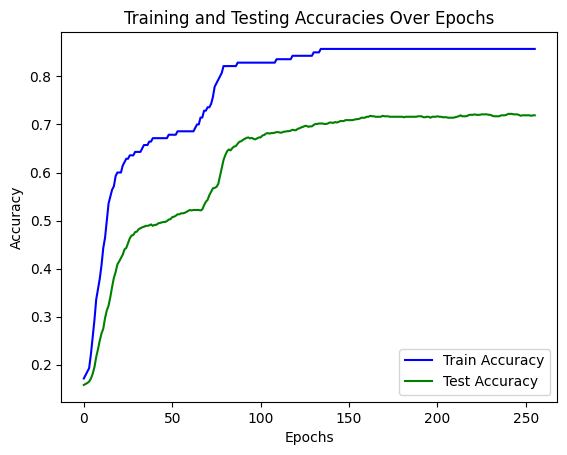

Final test accuracy: 0.719


In [16]:
model.reset_parameters() # I don't know why this doesn't reset model parameters :( yet I'm still using it here and in later blocks
train_accuracies, test_accuracies = train(model, data, adj_matrix, params)

plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies Over Epochs')
plt.legend()
plt.show()

print("Final test accuracy:", test_accuracies[-1])

## Part 2: Ablation Studies (Optional)

### 2.1: Importance of GNN and MLP modules
Add a parameter to the `CoraNodeClassification` class that allows you to select which modules to enable: only GNN, only MLP, or both. For example, your `forward` should look similarly to the following:

```python
def forward(self, x, adj_matrix):
	if self.gnn is not None:
		x = self.gnn(x, adj_matrix)
	
	if self.mlp is not None:
		x = self.mlp(x)

	return x
```

What is the impact of the two modules on the final result? Play a little around `hidden_features` and `num_layers` and briefly describe what you observe.

In [17]:
class CoraNodeClassification_mode(nn.Module):

	def __init__(self, input_dim, hidden_dim, output_dim, gnn_act_fn, mlp_act_fn):
		super(CoraNodeClassification_mode, self).__init__()
		self.input_dim = input_dim
		self.hidden_dim = hidden_dim
		self.output_dim = output_dim
		self.gnn = GNNModule(input_dim, hidden_dim, hidden_dim, act_fn = gnn_act_fn)
		self.mlp = MLPModule(hidden_dim, hidden_dim, output_dim, act_fn = mlp_act_fn)
		self.gnn_only = GNNModule(input_dim, hidden_dim, output_dim, act_fn = gnn_act_fn)
		self.mlp_only = MLPModule(input_dim, hidden_dim, output_dim, act_fn = mlp_act_fn)
		self.loss_fn = nn.CrossEntropyLoss()

	def forward(self, features, adj_matrix, mode = "both"):
		# mode : gnn, mlp, both
		if mode == "gnn":
			x = self.gnn_only(features, adj_matrix)
		elif mode == "mlp":
			x = self.mlp_only(features)
		else:
			x = self.gnn(features, adj_matrix)
			x = self.mlp(x)
		return x


	# Used to reset the weights of the network when training multiple times with
	# different hyperparameters
	def reset_parameters(self):
		def _reset_module_parameters(module):
			for layer in module.children():
				if hasattr(layer, 'reset_parameters'):
					layer.reset_parameters()
				elif hasattr(layer, 'children'):
					for child_layer in layer.children():
						_reset_module_parameters(child_layer)

		_reset_module_parameters(self)

In [18]:
model = CoraNodeClassification_mode(num_features,
							   params["hidden_features"],
							   num_classes,
							   gnn_act_fn=nn.ReLU, #ID is the identity function, replace it with the activation function you'd like to use
							   mlp_act_fn=nn.ReLU
  ).to(device)

In [19]:
def train(model, data, adj_matrix, params, mode = "both"):
	model.train()  # Set the model to training mode
	optimizer = torch.optim.Adam(
		model.parameters(),
		lr=params["learning_rate"],
		weight_decay=params["weight_decay"]
	)

	# Lists to store metrics over epochs
	losses = []
	train_accuracies = []
	test_accuracies = []

	for epoch in range(params["num_epochs"]):
		optimizer.zero_grad()
		out = model(data.x, adj_matrix, mode = mode)
		loss = model.loss_fn(out[data.train_mask], data.y[data.train_mask])

		loss.backward()
		optimizer.step()

		pred = out.argmax(dim=1)
		train_correct = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
		train_accuracy = train_correct / data.train_mask.sum().item()

		# Evaluate test accuracy
		model.eval()
		with torch.no_grad():
			test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
			test_accuracy = test_correct / data.test_mask.sum().item()
		model.train()  # Switch back to training mode

		# Store metrics
		losses.append(loss.item())
		train_accuracies.append(train_accuracy)
		test_accuracies.append(test_accuracy)

		# Print metrics at intervals
		if epoch % params.get("log_interval", 10) == 0:
			print(f"Epoch {epoch}/{params['num_epochs']} - Loss: {loss.item():.4f}, "
				  f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

	return train_accuracies, test_accuracies


Epoch 0/256 - Loss: 2.2493, Train Accuracy: 0.1214, Test Accuracy: 0.2450
Epoch 10/256 - Loss: 1.7499, Train Accuracy: 0.4071, Test Accuracy: 0.3810
Epoch 20/256 - Loss: 1.5710, Train Accuracy: 0.5000, Test Accuracy: 0.4460
Epoch 30/256 - Loss: 1.4247, Train Accuracy: 0.5500, Test Accuracy: 0.4820
Epoch 40/256 - Loss: 1.2880, Train Accuracy: 0.6143, Test Accuracy: 0.5140
Epoch 50/256 - Loss: 1.0669, Train Accuracy: 0.7143, Test Accuracy: 0.5550
Epoch 60/256 - Loss: 0.9580, Train Accuracy: 0.7286, Test Accuracy: 0.5620
Epoch 70/256 - Loss: 0.8770, Train Accuracy: 0.7286, Test Accuracy: 0.5650
Epoch 80/256 - Loss: 0.8185, Train Accuracy: 0.7357, Test Accuracy: 0.5610
Epoch 90/256 - Loss: 0.7719, Train Accuracy: 0.7357, Test Accuracy: 0.5600
Epoch 100/256 - Loss: 0.7342, Train Accuracy: 0.7357, Test Accuracy: 0.5700
Epoch 110/256 - Loss: 0.6953, Train Accuracy: 0.7786, Test Accuracy: 0.5740
Epoch 120/256 - Loss: 0.5285, Train Accuracy: 0.8571, Test Accuracy: 0.6140
Epoch 130/256 - Loss: 0

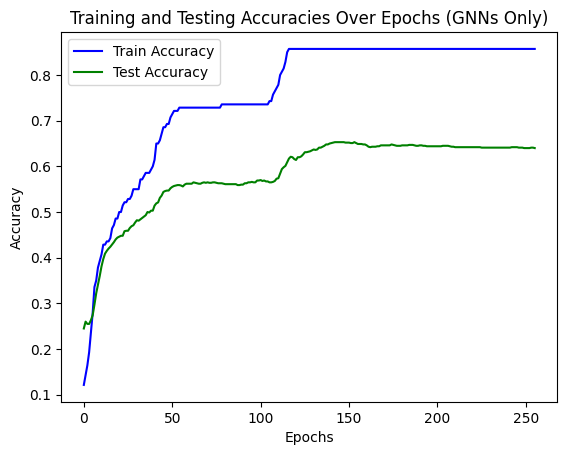

Final test accuracy: 0.64


In [20]:
# GNN ONLY
model.reset_parameters()
train_accuracies, test_accuracies = train(model, data,  adj_matrix, params, mode = "gnn")

plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies Over Epochs (GNNs Only)')
plt.legend()
plt.show()

print("Final test accuracy:", test_accuracies[-1])

Epoch 0/256 - Loss: 1.9456, Train Accuracy: 0.1429, Test Accuracy: 0.1300
Epoch 10/256 - Loss: 1.9302, Train Accuracy: 0.3429, Test Accuracy: 0.1620
Epoch 20/256 - Loss: 1.9141, Train Accuracy: 0.4714, Test Accuracy: 0.2040
Epoch 30/256 - Loss: 1.8956, Train Accuracy: 0.5214, Test Accuracy: 0.2480
Epoch 40/256 - Loss: 1.8741, Train Accuracy: 0.6000, Test Accuracy: 0.2940
Epoch 50/256 - Loss: 1.8490, Train Accuracy: 0.6429, Test Accuracy: 0.3300
Epoch 60/256 - Loss: 1.8191, Train Accuracy: 0.6714, Test Accuracy: 0.3580
Epoch 70/256 - Loss: 1.7852, Train Accuracy: 0.6929, Test Accuracy: 0.3850
Epoch 80/256 - Loss: 1.7479, Train Accuracy: 0.7000, Test Accuracy: 0.4010
Epoch 90/256 - Loss: 1.7075, Train Accuracy: 0.7000, Test Accuracy: 0.4170
Epoch 100/256 - Loss: 1.6644, Train Accuracy: 0.7000, Test Accuracy: 0.4240
Epoch 110/256 - Loss: 1.6187, Train Accuracy: 0.7071, Test Accuracy: 0.4310
Epoch 120/256 - Loss: 1.5711, Train Accuracy: 0.7143, Test Accuracy: 0.4320
Epoch 130/256 - Loss: 1

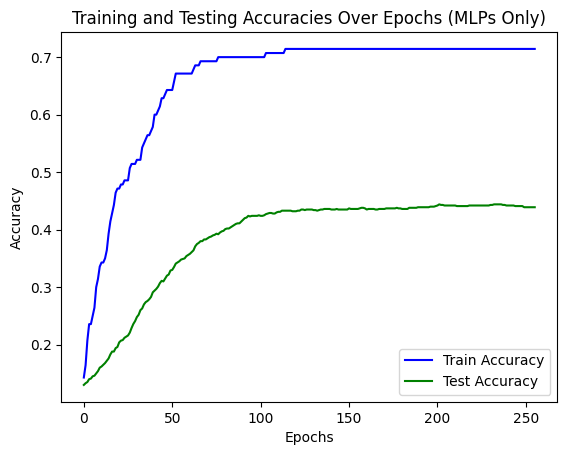

Final test accuracy: 0.439


In [21]:
# MLP ONLY
model.reset_parameters()
train_accuracies, test_accuracies = train(model, data, adj_matrix, params, mode = 'mlp')

plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies Over Epochs (MLPs Only)')
plt.legend()
plt.show()

print("Final test accuracy:", test_accuracies[-1])

### 2.2: Importance of non-linearities
Try to replace all your activation functions with identities (or simply remove them). Do the results change? What does this tell you about this specific problem?

In [22]:
# Set a new model with identity activations
model = CoraNodeClassification_mode(num_features,
							   params["hidden_features"],
							   num_classes,
							   gnn_act_fn=nn.Identity, #ID is the identity function, replace it with the activation function you'd like to use
							   mlp_act_fn=nn.Identity
  ).to(device)

Epoch 0/256 - Loss: 2.0571, Train Accuracy: 0.1643, Test Accuracy: 0.1730
Epoch 10/256 - Loss: 1.5077, Train Accuracy: 0.6357, Test Accuracy: 0.5170
Epoch 20/256 - Loss: 1.2323, Train Accuracy: 0.7786, Test Accuracy: 0.6580
Epoch 30/256 - Loss: 1.0109, Train Accuracy: 0.9143, Test Accuracy: 0.7080
Epoch 40/256 - Loss: 0.8248, Train Accuracy: 0.9500, Test Accuracy: 0.7370
Epoch 50/256 - Loss: 0.6671, Train Accuracy: 0.9786, Test Accuracy: 0.7460
Epoch 60/256 - Loss: 0.5361, Train Accuracy: 0.9857, Test Accuracy: 0.7510
Epoch 70/256 - Loss: 0.4290, Train Accuracy: 1.0000, Test Accuracy: 0.7520
Epoch 80/256 - Loss: 0.3429, Train Accuracy: 1.0000, Test Accuracy: 0.7470
Epoch 90/256 - Loss: 0.2740, Train Accuracy: 1.0000, Test Accuracy: 0.7530
Epoch 100/256 - Loss: 0.2190, Train Accuracy: 1.0000, Test Accuracy: 0.7520
Epoch 110/256 - Loss: 0.1750, Train Accuracy: 1.0000, Test Accuracy: 0.7530
Epoch 120/256 - Loss: 0.1400, Train Accuracy: 1.0000, Test Accuracy: 0.7570
Epoch 130/256 - Loss: 0

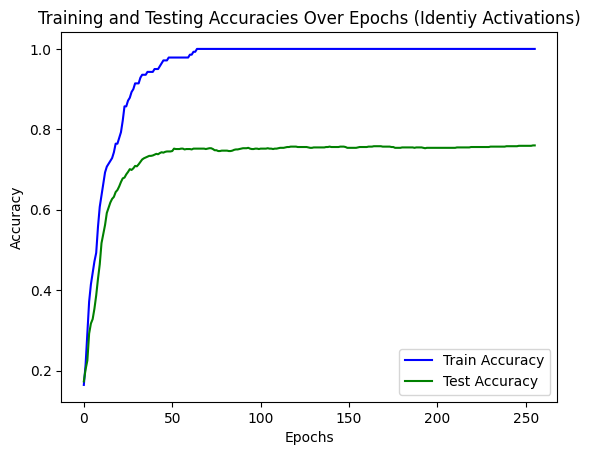

Final test accuracy: 0.76


In [23]:
train_accuracies, test_accuracies = train(model, data, adj_matrix, params, mode = 'both')

plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies Over Epochs (Identiy Activations)')
plt.legend()
plt.show()

print("Final test accuracy:", test_accuracies[-1])